This notebook is used to experiment with minimizing the search space for the emission lines when applying to neural networks convolutions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import h5py
from numba import vectorize

C:\Users\stone\Miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
eboss = pd.read_csv('../../Data/Astronomy.csv')
manga = pd.read_csv('../../Data/Astronomy20000_Original.csv')

Simple helper method to read manga file from id. Change the file_loc directory to match your local configuration.

In [3]:
def get_fits_from_id(manga_id):
    pieces = manga_id.split('_')
    file_loc = '../../../AstroProj/Data/RawManga/HIT_RSS_mpl5_{plate_id}_{mjd}_fiber_{fiber_id}_{file_type}.fits'.format(
        plate_id = pieces[0], 
        mjd=pieces[1], 
        fiber_id=pieces[3], 
        file_type=pieces[4]
    )
    
    return fits.open(file_loc)

Adding the foreground z-value to the set.

In [4]:
foreground_zs = []
for row in manga.itertuples():
    spec = get_fits_from_id(row.id)
    try:
        foreground_zs.append(spec[0].header['NSA_Z'])
    except KeyError:
        print(row.id)
        foreground_zs.append(-9999)
    spec.close()
manga['fore_z'] = pd.Series(foreground_zs)

8149_3704_fiber_0_multiline
8329_12702_fiber_0_oneline
8456_12702_fiber_0_oneline
8256_6101_fiber_0_oneline
8456_12702_fiber_0_multiline
8462_3701_fiber_0_oneline
8464_3702_fiber_0_oneline
8484_3701_fiber_0_oneline
8604_9102_fiber_0_oneline
8952_6102_fiber_0_oneline
7991_12701_fiber_0_oneline
8143_6103_fiber_0_multiline
9042_3702_fiber_0_oneline


Getting the difference values for the rows with valid z-values.

In [5]:
diff = manga[manga.fore_z != -9999.0].z - manga[manga.fore_z != -9999.0].fore_z
manga[manga.fore_z != -9999.0][diff > 0][['fore_z', 'z', 'id']].head()

,fore_z,z,id
0,0.055367,1.319360,8146_12703_fiber_781_oneline
1,0.055367,0.948802,8146_12703_fiber_916_oneline
2,0.062771,1.501310,8146_12704_fiber_1166_oneline
3,0.062771,1.603560,8146_12704_fiber_1172_oneline
4,0.062771,1.357040,8146_12704_fiber_1187_oneline
5,0.062771,1.670960,8146_12704_fiber_138_oneline
6,0.062771,1.670350,8146_12704_fiber_1426_oneline
7,0.062771,1.079060,8146_12704_fiber_1431_oneline
8,0.062771,0.851688,8146_12704_fiber_459_oneline
9,0.062771,0.643493,8146_12704_fiber_480_oneline


In [10]:
min_fits = get_fits_from_id(manga[manga.z == manga.z.min()].id.iloc[0])
max_fits = get_fits_from_id(manga[manga.z == manga.z.max()].id.iloc[0])

Quick loop to check over some values.

In [5]:
wave_len, min_wave, max_wave = [], [], []
first_wave = get_fits_from_id(list(manga.itertuples())[0].id)[2].data
for row in manga.itertuples():
    spec = get_fits_from_id(row.id)
    min_wave.append(spec[2].data.min())
    max_wave.append(spec[2].data.max())
    wave_len.append(len(spec[7].data))
    if not np.all(first_wave == spec[2].data):
        print("WRONG")
    
    spec.close()

In [6]:
set(min_wave), set(max_wave), set(wave_len)

({3621.5959848601933}, {10353.805444147549}, {4563})

Average difference between the values in the waves vector. Need to use the max instead of the min to ensure all values are being captured

(array([741., 632., 552., 489., 440., 399., 366., 338., 313., 292.]),
 array([0.83399931, 0.98897711, 1.14395492, 1.29893272, 1.45391053,
        1.60888833, 1.76386614, 1.91884394, 2.07382174, 2.22879955,
        2.38377735]),
 <a list of 10 Patch objects>)

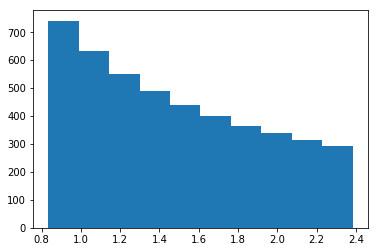

In [24]:
plt.hist((wave[1:] - wave[:-1]))

Main method for generating the expanded feature array.

In [6]:
OIIA = manga.iloc[0,14:27].OIIA
OIIB = manga.iloc[0,14:27].OIIB
OIIIA = manga.iloc[0,14:27].OIIIA

wave = get_fits_from_id(list(manga.itertuples())[0].id)[2].data

emsn_lines = [(OIIA+OIIB)/2, OIIIA]

max_wave_val = 10353.805444147549
min_wave_val = 3621.5959848601933

epsilon = 20

z_range = np.arange(manga.z.min(), manga.z.max(), .05)
print(len(z_range))

@np.vectorize
def calc_emis(z, em):
    return (1 + z)*em

def generate_expanded_observation(z_range, epsilon, emsn_lines, wave, flux, min_wave_val=3621.5959848601933, max_wave_val=10353.805444147549):
    """
    This method transforms given manga observation into a NxM feature stack. It hopefully contains all the possible locations of the 
    emission lines to make it easier for the model to learn from.
    
    N = number of valid z-values to test.
    M = epsilon*2*num_emissions
    """
    
    # Calculating the maximum, and minimum emission given.
    min_emsn, max_emsn = min(emsn_lines), max(emsn_lines)
    
    # Calculate the minimum, and maximum possible z-values.
    # This is expecting the calc_emis function to be vectorized.
    max_wave_diff = (wave[1:] - wave[:-1]).max()
    min_z_vals = calc_emis(z_range, min_emsn) - (epsilon*max_wave_diff)
    max_z_vals = calc_emis(z_range, max_emsn) + (epsilon*max_wave_diff)
    
    #Ensure lower and lower bound is within range.
    z_range = z_range[np.where((min_z_vals >= min_wave_val) & (min_z_vals <= max_wave_val))]
    z_range = z_range[np.where((max_z_vals >= min_wave_val) & (max_z_vals <= max_wave_val))]
    
    # Generate the expanded feature array.
    expanded_features = np.ndarray((len(z_range), epsilon*len(emsn_lines)*2))
    
    # For each emissions line
    for num_emission, emsn in enumerate(emsn_lines):
        
        # Calculate all the zshifts for different acceptable zvalues.
        z_shifts = calc_emis(z_range, emsn)
        z_ixs = np.array([np.argmin(np.abs(wave-z)) for z in z_shifts])
        
        # Generating slices for indexing into the wave array.
        slices = np.array([range(s,e) for s, e in zip(z_ixs-epsilon,z_ixs+epsilon)])
        
        # Generating start and end iteration points.
        start = num_emission*epsilon*2
        end = start + epsilon*2
        
        # Setting the actual values.
        expanded_features[:, start:end] = flux[slices]
    
    return expanded_features

36


Example usage

In [46]:
ef = generate_expanded_observation(z_range, epsilon, emsn_lines, wave, get_fits_from_id(manga_ids.id.iloc[0].decode())[7].data)

Remove duplicates and generate the dataset

In [7]:
manga_data = pd.read_csv('../../Data/Astronomy20000_Original.csv')
# Extract the duplicates
excat_duplicates = manga_data[manga_data.duplicated(keep='last')]
id_duplicates_excluding_excat = manga_data[~manga_data.duplicated(keep=False) & manga_data.duplicated(subset='id', keep=False)]
# Drop them.
manga_data.drop(excat_duplicates.index, inplace=True)
manga_data.drop(id_duplicates_excluding_excat.index, inplace=True)
manga_ids = manga_data[['id', 'Hits']]

# Place fitler here.
manga_ids = manga_ids[manga_ids.id.str.contains('multiline')]

In [30]:
file = h5py.File('../../Data/manga_multiline_expanded.hdf5', mode='w')

# del file['res_flux_values']
# del file['res_flux_values_expanded']
# del file['flux_labels']
# del file['flux_ids']

label_mapper = lambda x: 0 if x == 'bad' else 1
file.create_dataset('res_flux_values', shape=(len(manga_ids), 4563))
file.create_dataset('res_flux_values_expanded', shape=(len(manga_ids), 21, 80))
file.create_dataset('flux_labels', shape=(len(manga_ids), 1))
file.create_dataset('flux_ids', shape=(len(manga_ids), 1), dtype='S33')
manga_ids.id = manga_ids.id.astype('S')

for ix, row in enumerate(manga_ids.itertuples()):
    spec = get_fits_from_id(row.id.decode())
    file['res_flux_values'][ix] = spec[7].data
    file['res_flux_values_expanded'][ix] = generate_expanded_observation(z_range, epsilon, emsn_lines, wave, spec[7].data)
    
    file['flux_labels'][ix] = label_mapper(row.Hits)
    file['flux_ids'][ix] = row.id
    spec.close()
    
file.close()

Generating images from the expanded features.

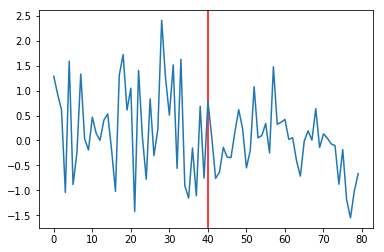

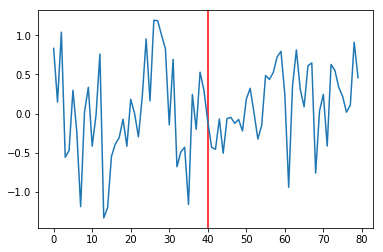

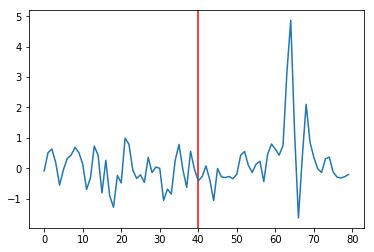

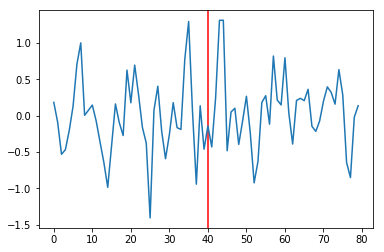

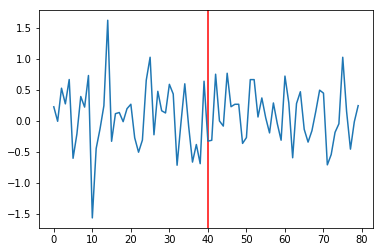

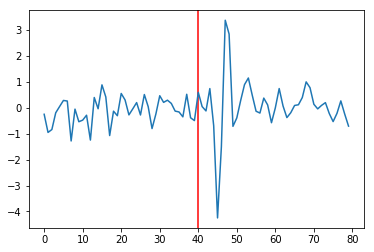

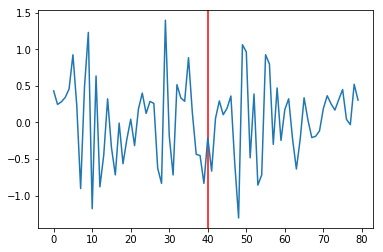

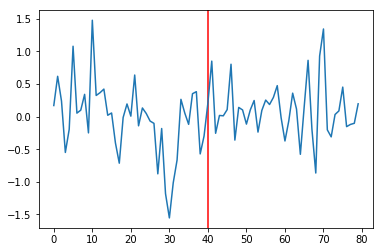

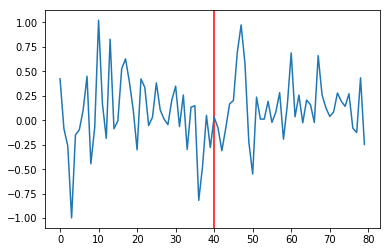

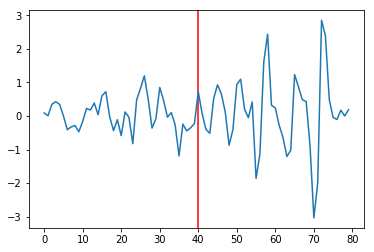

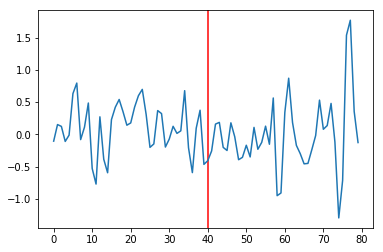

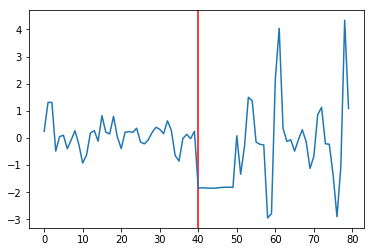

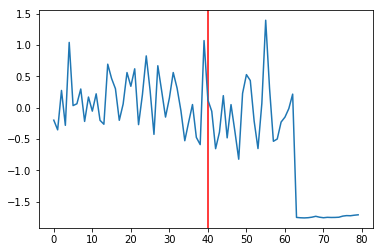

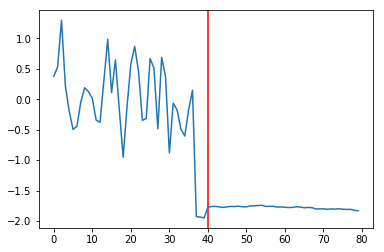

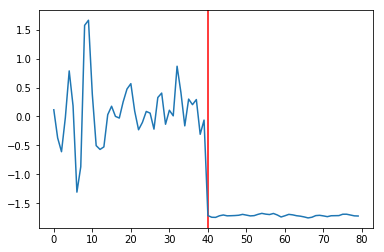

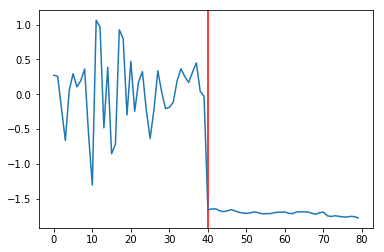

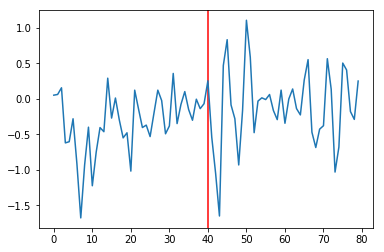

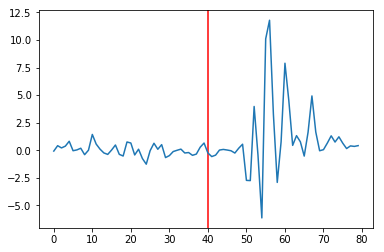

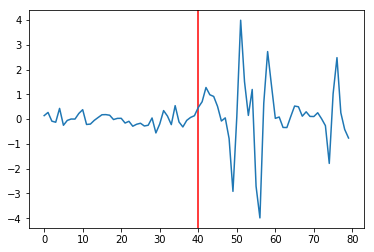

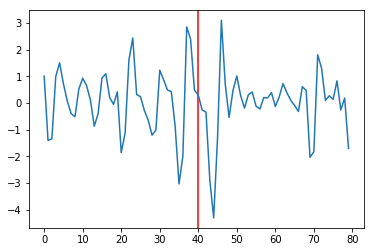

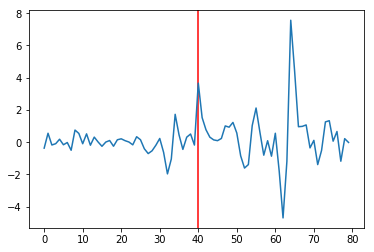

In [35]:
file = h5py.File('../../Data/manga_multiline_expanded.hdf5', mode='r')
for ix in range(21):
    plt.axvline(40, c='red')
    plt.plot(range(len(file['res_flux_values_expanded'][0][ix])), file['res_flux_values_expanded'][0][ix])
    plt.show()
file.close()

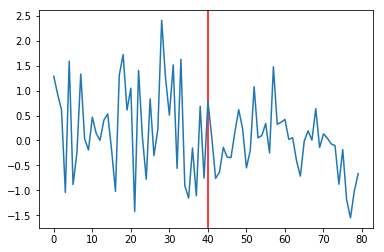

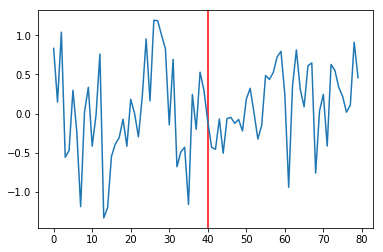

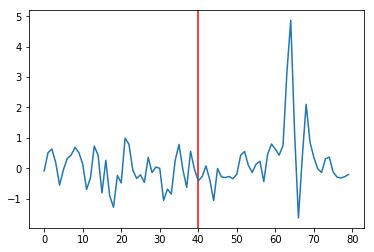

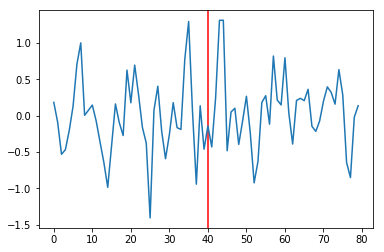

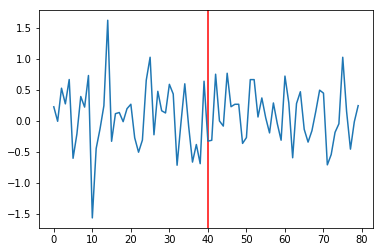

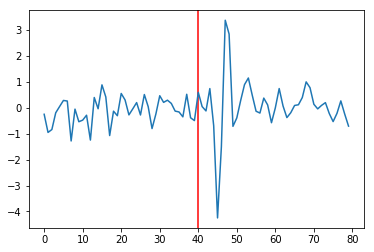

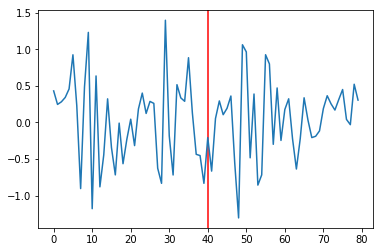

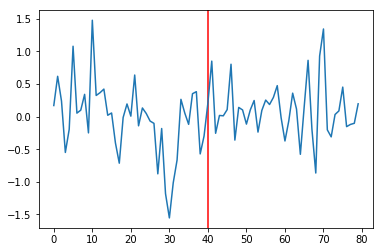

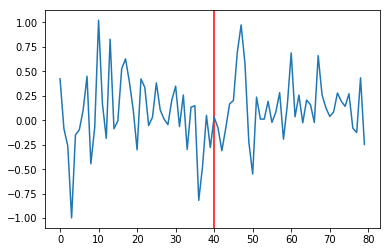

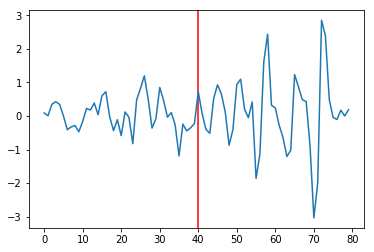

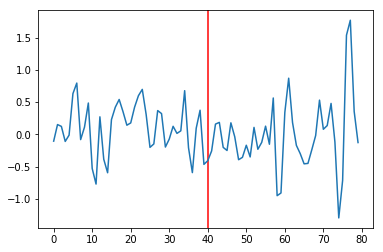

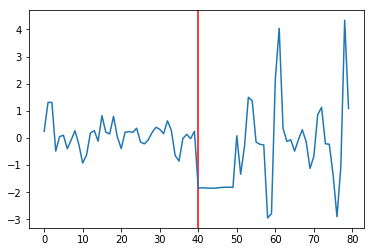

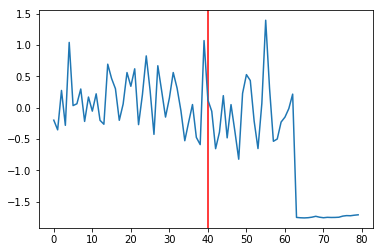

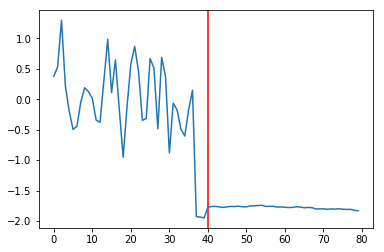

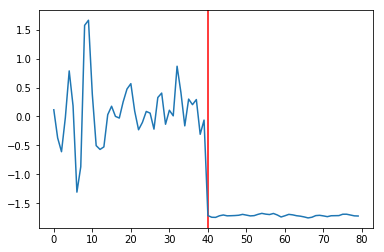

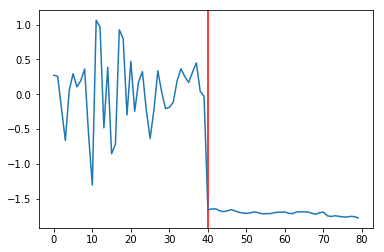

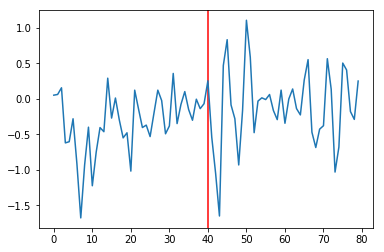

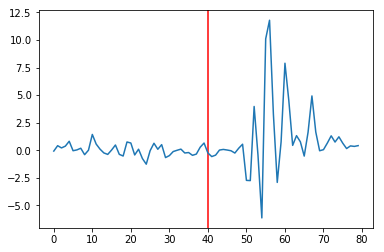

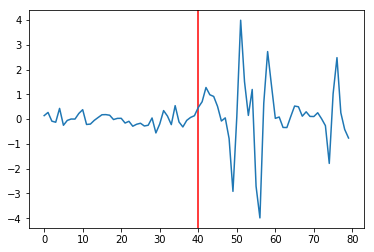

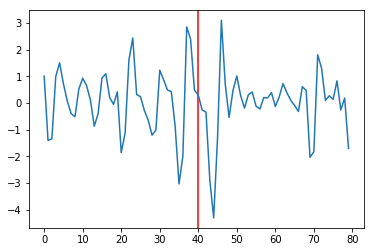

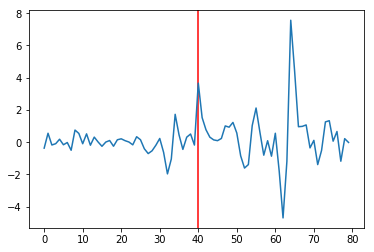

In [47]:
for ix in range(ef.shape[0]):
    plt.axvline(40, c='red')
    plt.plot(range(len(ef[ix])), ef[ix])
    plt.show()